In [2]:
import numpy as np
import plotly.graph_objects as go
import sys
import pandas as pd
import copy
from tqdm import tqdm
import cv2
sys.path.append("../")
from layers import get_layers
from states import States
import TD3
import utils
from hyperparameters import get_hyperparameters
from common import make_env, create_folders, make_env_cc

In [44]:
env_name = "InvertedPendulum-v2"
p = 0.5
augment_type = "sla"
lcs = []
for seed in range(10):
    arguments = [augment_type, env_name, seed, p]
    file_name = '_'.join([str(x) for x in arguments])
    total = np.load(f"../results/{file_name}.npy")
    lcs.append(total)
    
# td3 = []   
# for seed in range(10):
#     arguments = [env_name, seed]
#     file_name = '_'.join([str(x) for x in arguments])
#     total = np.load(f"../results/{file_name}.npy")
#     td3.append(total)
    
lcs = np.array(lcs)
lcs = np.mean(lcs, axis=0)

# td3 = np.array(td3)
# td3 = np.mean(td3, axis=0)

c:\python37\lib\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: operands could not be broadcast together with shapes (3,) (200,) 

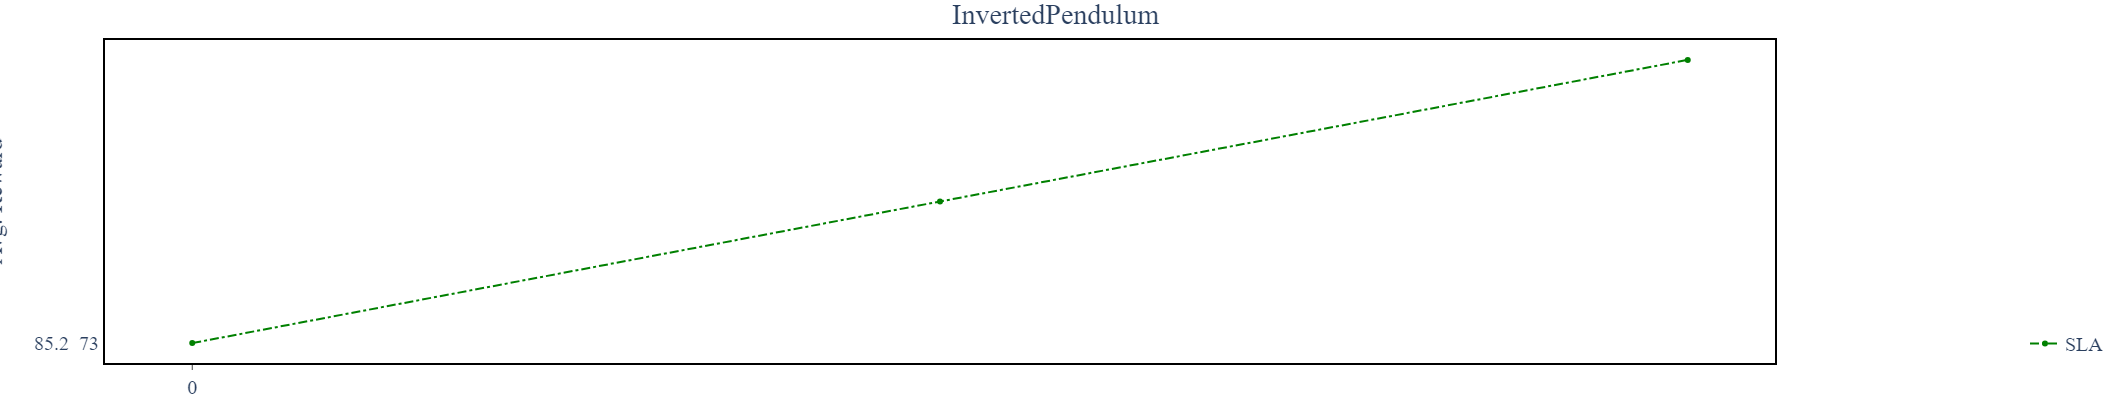

In [ ]:
fig = go.Figure()

x = list(i*5000 for i in range(total.shape[0]))

fig.add_trace(go.Scatter(
    x=x, y=lcs,
    line_color='Green',
    name='SLA',
     line=dict(dash='dashdot', width=2)
))


# fig.add_trace(go.Scatter(
#     x=x, y=td3,
#     line_color='Blue',
#     name='TD3',
#     line=dict(width=2)
# ))


fig.update_layout(width=800, height=400,  
                  margin=dict(
        l=2,
        r=2,
        b=2,
        t=40,
        pad=0
    ), 
                  title={
        'text': "InvertedPendulum",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    , 
                  yaxis_title="Avg. Reward", 
                   font_family="Times New Roman",
                title_font_family="Times New Roman",
                  font_size=20,
                  legend=dict(
                        yanchor="bottom",
                        y=0.0,
                        xanchor="right",
                        x=1.2,
                    ), 
                  showlegend=True, plot_bgcolor = "white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 200000,
        gridcolor="LightGrey",
        griddash="dash",
        mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black'
        
    ),  yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 200,
        gridcolor="LightGrey",
         griddash="dash",
                mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black'
    ))

In [9]:
env_name = "InvertedPendulum-v2"
layers = get_layers(env_name)
num_layers = layers['layers']
hy = get_hyperparameters(env_name)
timestep = hy['timestep']
env = make_env(env_name, 0, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
p = 0.5
kwargs = {"state_dim": state_dim, "action_dim": action_dim, "max_action": max_action, "discount": hy['discount'],
          "tau": hy['tau'],
          "policy_noise": hy['policy_noise'] * max_action, "noise_clip": hy['noise_clip'] * max_action,
          "policy_freq": hy['policy_freq'], "neurons": [400, 300]}

dfall = pd.DataFrame(columns=["seed", "noise", "avg. Reward"])

for seed in tqdm(range(10)):
    policies = []
    augment_type = "sla"
    arguments = [augment_type, env_name, seed, p]
    file_name = '_'.join([str(x) for x in arguments])
    for l in range(num_layers):
        k = copy.deepcopy(kwargs)
        if l < num_layers - 1:
            k["removed_indices"] = layers['layer' + str(l + 1)]
            policy = TD3.TempoRLTLA(**k)
        else:
            policy = TD3.TD3(**k)
        policy.load(f"../models/{file_name}_l{l+1}_layer_best")
        policies.append(policy)

    for i in range(21):
        env = make_env(env_name, seed+100, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
        noise = i * 0.05
        eval_reward = 0
        for i in range(10):
            eval_state, eval_done = env.reset(), False
            while not eval_done:

                removed_dim = -1
                if np.random.random() < noise:
                    # removed_dim = np.random.randint(2)
                    # if removed_dim == 0:
                    removed_dim = 0
                    # eval_state[0] = 0
                    # else:
                    eval_state[0:2] = 0

                if removed_dim == -1:
                    eval_action = policies[1].select_action(eval_state)
                else:
                    eval_action = policies[0].select_action(eval_state)
                eval_next_state, eval_r, eval_done, _ = env.step(eval_action)
                eval_reward += eval_r
                eval_state = eval_next_state

        avg_reward = eval_reward/10
        dfall.loc[len(dfall)] = [seed, noise, avg_reward]
        
dfsla = dfall

c:\python37\lib\site-packages\gym\spaces\box.py:74: UserWarning:

WARN: Box bound precision lowered by casting to float32

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.29s/it]


In [45]:
env_name = "InvertedPendulum-v2"
layers = get_layers(env_name)
num_layers = layers['layers']
hy = get_hyperparameters(env_name)
timestep = hy['timestep']
env = make_env(env_name, 0, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
p = 0.5
kwargs = {"state_dim": state_dim, "action_dim": action_dim, "max_action": max_action, "discount": hy['discount'],
          "tau": hy['tau'],
          "policy_noise": hy['policy_noise'] * max_action, "noise_clip": hy['noise_clip'] * max_action,
          "policy_freq": hy['policy_freq'], "neurons": [400, 300]}

dfall = pd.DataFrame(columns=["seed", "noise", "avg. Reward"])

for seed in tqdm(range(10)):
    policies = []
    augment_type = "sla"
    arguments = [augment_type, env_name, seed, p]
    file_name = '_'.join([str(x) for x in arguments])
    for l in range(num_layers):
        k = copy.deepcopy(kwargs)
        if l < num_layers - 1:
            k["removed_indices"] = layers['layer' + str(l + 1)]
            policy = TD3.TempoRLTLA(**k)
        else:
            policy = TD3.TD3(**k)
        policy.load(f"../models/{file_name}_l{l+1}_layer_best")
        policies.append(policy)

    for i in range(21):
        env = make_env(env_name, seed, clock_wrapper=layers['clock'], clock_dim=layers['clock_dim'], prev_action_wrapper=layers['previous_action'])
        noise = i * 0.05
        eval_reward = 0
        for i in range(10):
            eval_state, eval_done = env.reset(), False
            while not eval_done:

                removed_dim = 0
                if np.random.random() < noise:
                    # removed_dim = np.random.randint(2)
                    # if removed_dim == 0:
                    removed_dim = 0
                    # eval_state[0] = 0
                    # else:
                    eval_state[0:2] = 0

                if removed_dim == -1:
                    eval_action = policies[1].select_action(eval_state)
                else:
                    eval_action = policies[0].select_action(eval_state)
                eval_next_state, eval_r, eval_done, _ = env.step(eval_action)
                eval_reward += eval_r
                eval_state = eval_next_state

        avg_reward = eval_reward/10
        dfall.loc[len(dfall)] = [seed, noise, avg_reward]
        
df1 = dfall

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


In [31]:
dfsla = dfsla.groupby(['noise']).mean()
df1 = df1.groupby(['noise']).mean()
# df2 = df2.groupby(['noise']).mean()
# df3 = df3.groupby(['noise']).mean()
# dftd3 = dftd3.groupby(['noise']).mean()
# dftdpos = dftdpos.groupby(['noise']).mean()
# dfno = dfno.groupby(['noise']).mean()

In [32]:
df1

,seed,avg. Reward
noise,,
0.00,4.5,7.44
0.05,4.5,7.44
0.10,4.5,7.44
0.15,4.5,7.44
0.20,4.5,7.44
0.25,4.5,7.44
0.30,4.5,7.44
0.35,4.5,7.44
0.40,4.5,7.44


In [21]:
dfsla.to_csv('velpos_dfsla.csv')
df1.to_csv('velpos_df1.csv')
# df2.to_csv('velpos_df2.csv')
# df3.to_csv('velpos_df3.csv')
# dftd3.to_csv('velpos_dftd3.csv')
# dfno.to_csv('velpos_dfno.csv')
# dftdpos.to_csv('velpos_dftdpos.csv')

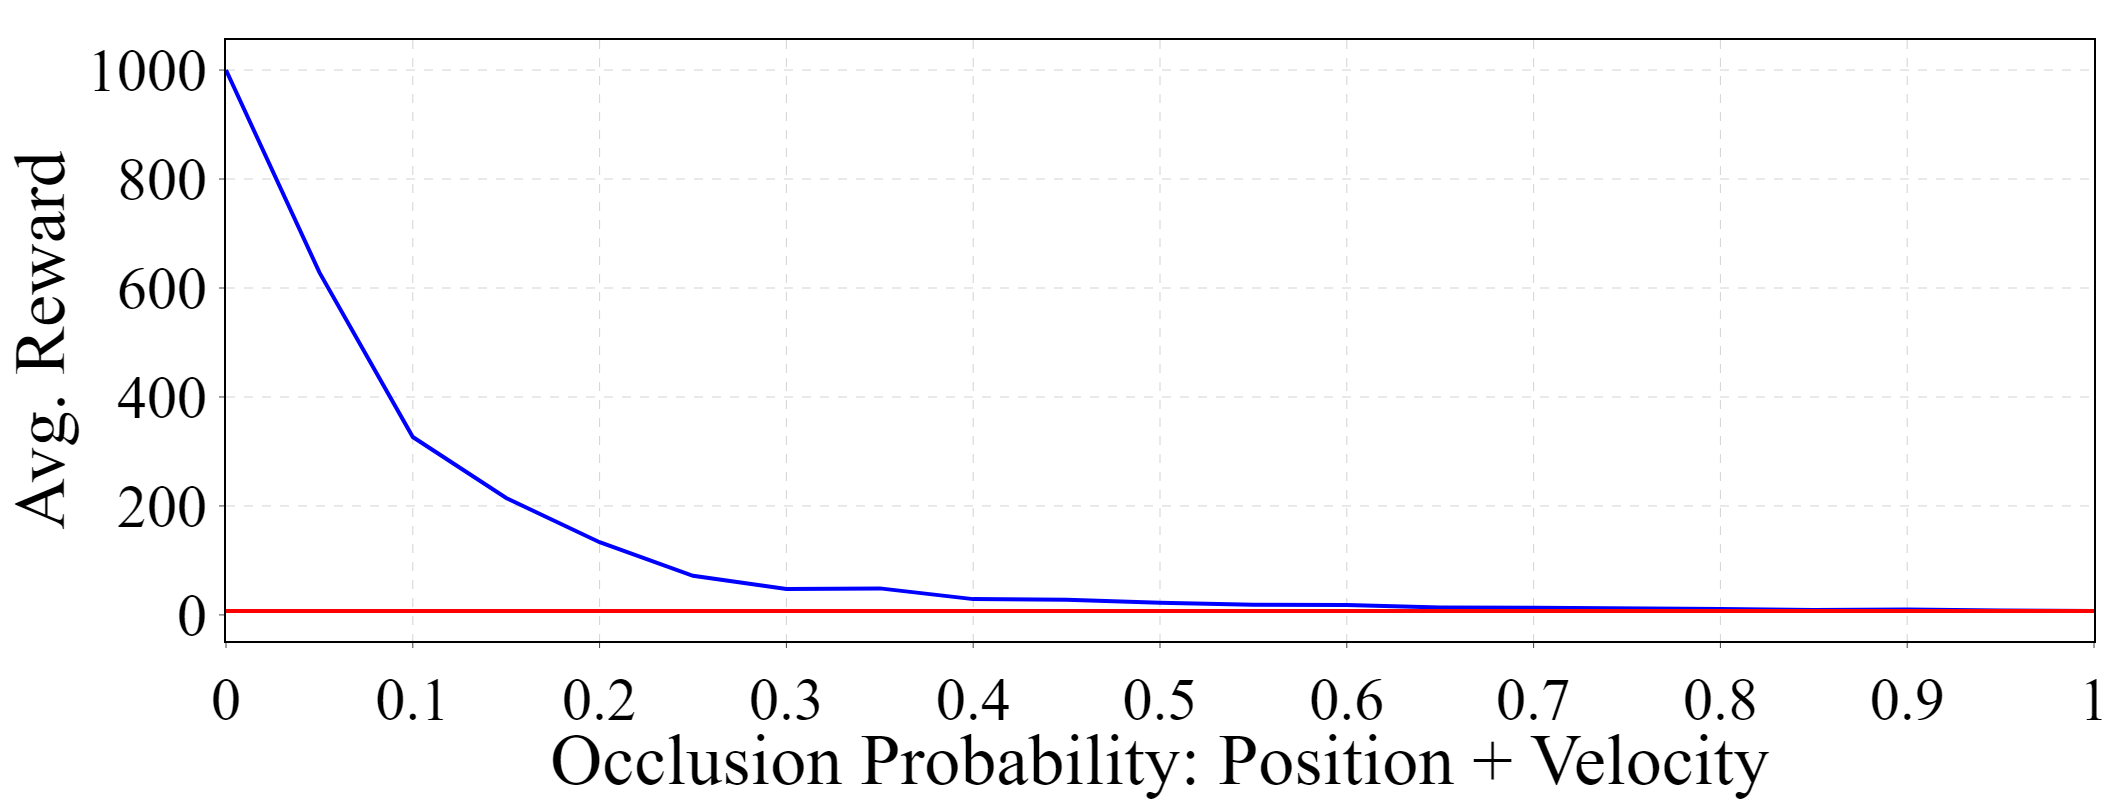

In [22]:
fig = go.Figure()

x = [x for x in dfsla.index]

# fig.add_trace(go.Scatter(
#     x=x, y=dftd3["avg. Reward"],
#     line_color='Green',
#     name='TD3',
#      line=dict(dash='dashdot', width=4)
# ))

# fig.add_trace(go.Scatter(
#     x=x, y=dftdpos["avg. Reward"],
#     line_color='Grey',
#     name='TD3-POS',
#      line=dict(dash='dashdot', width=4)
# ))

# fig.add_trace(go.Scatter(
#     x=x, y=dfno["avg. Reward"],
#     line_color='Maroon',
#     name='TD3-Internal',
#      line=dict(dash='dashdot', width=4)
# ))

fig.add_trace(go.Scatter(
    x=x, y=dfsla["avg. Reward"],
    line_color='Blue',
    name='SLA',
    line=dict(width=4)
))


fig.add_trace(go.Scatter(
    x=x, y=df1["avg. Reward"],
    line_color='Red',
    name='Layer 1',
    line=dict(width=4)
))

# fig.add_trace(go.Scatter(
#     x=x, y=df2["avg. Reward"],
#     line_color='Purple',
#     name='Layer 2',
#     line=dict(width=4)
# ))

# fig.add_trace(go.Scatter(
#     x=x, y=df3["avg. Reward"],
#     line_color='Black',
#     name='Layer 3',
#     line=dict(width=4)
# ))


fig.update_layout(width=1600, height=800,  
                  margin=dict(
        l=2,
        r=2,
        b=2,
        t=40,
        pad=0
    ), 
    #               title={
    #     'text': "Mountain Car Robustness",
    #     'y':1,
    #     'x':0.5,
    #     'xanchor': 'center',
    #     'yanchor': 'top'}
    # , 
                  yaxis_title="Avg. Reward", 
                  xaxis_title="Occlusion Probability: Position + Velocity", 
                   font_family="Times New Roman",
                title_font_family="Times New Roman",
                  font_color="black",
                  font_size=60,
                  legend=dict(
                        yanchor="bottom",
                        y=0.0,
                        xanchor="right",
                        x=1.4,
                    ), 
                  showlegend=False, plot_bgcolor = "white",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.1,
        gridcolor="LightGrey",
        griddash="dash",
        mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black'
        
    ),  yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 200,
        gridcolor="LightGrey",
         griddash="dash",
                mirror=True,
        ticks='outside',
        showline=True,
        linewidth=2,
        linecolor='black',
        title_standoff=35,
    ))

In [16]:
dfsla

,seed,avg. Reward
noise,,
0.00,4.5,1000.00
0.05,4.5,628.58
0.10,4.5,326.47
0.15,4.5,214.69
0.20,4.5,133.40
0.25,4.5,71.75
0.30,4.5,47.61
0.35,4.5,48.72
0.40,4.5,29.01
